# Summary

Lets fit the models to the actual data.

---
# Setup

In [1]:
# @title Imports
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from popy.simulation_tools import *
from popy.io_tools import load_behavior
from popy.behavior_data_tools import *

from simulation_helpers import simulate_agent, estimate_ll
from plotting_helpers import *


In [2]:
# data loading

def get_data_custom(monkey):
    behav_monkey = load_behavior(monkey)
    behav_monkey = drop_time_fields(behav_monkey)
    behav_monkey = add_switch_info(behav_monkey)
    behav_monkey = convert_column_format(behav_monkey, original='behavior')

    behav_monkey = behav_monkey.dropna()

    return behav_monkey


---
# Load behavior

In [3]:
monkey = 'po'

behav_monkey = get_data_custom(monkey)
#behav_monkey = pd.read_pickle('results/behavior_strategic_reset.pkl')

behav_monkey.head()

,monkey,session,trial_id,block_id,best_arm,action,reward,switch
23953,po,011220,1,0,1,0.0,0.0,0.0
23954,po,011220,2,0,1,0.0,0.0,0.0
23955,po,011220,3,0,1,1.0,1.0,1.0
23956,po,011220,4,0,1,1.0,0.0,0.0
23957,po,011220,5,0,1,2.0,0.0,1.0


# Create environment

In [4]:
# Create the environment
env = gym.make("zsombi/monkey-bandit-task-v0", n_arms=3, max_episode_steps=100_000)

# Set container (to collect pandas series into a dataframe)
results = {}
behaviors_simulated = {f'MONKEY {monkey.upper()}': behav_monkey}

---
# Fit models to the data

## 0. Baselines

### Repeating agent

An agent that repeats the previous action. Uses Softmax to choose the action.

epsilon            0.332435
LL_best       -10420.211201
BIC_best       20850.050334
LPT_best           0.503431
LL_CV          -3484.376332
LL_std           175.226450
BIC_CV          6977.281983
BIC_std          350.452901
LPT_CV             0.502542
LPT_std            0.017349
Reward rate        0.403550
Proba best         0.332560
dtype: float64

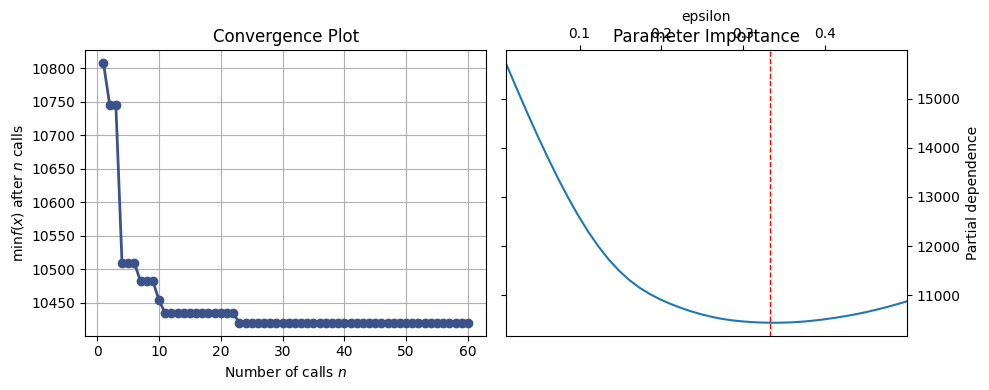

In [5]:
# Define parameter space for ShiftValueAgent
model_name = 'Repeating agent'
agent_class = RepeatingAgent

param_space = [
    Real(0.01, 0.5, name='epsilon'),
]

fixed_params = {}

# fit agent, get best params and simulation
res_temp, behavior_temp = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, CV_splits=3, make_plots=True, n_calls=60, n_initial_points=10, n_jobs=1)
results[model_name] = res_temp
behaviors_simulated[model_name] = behavior_temp

res_temp

### Simple WSLS

### Modified WSLS

epsilon            0.287438
LL_best        -9962.031505
BIC_best       19933.690941
LPT_best           0.518855
LL_CV          -3324.766435
LL_std            95.765736
BIC_CV          6658.062190
BIC_std          191.531472
LPT_CV             0.518498
LPT_std            0.009783
Reward rate        0.448970
Proba best         0.447830
dtype: float64

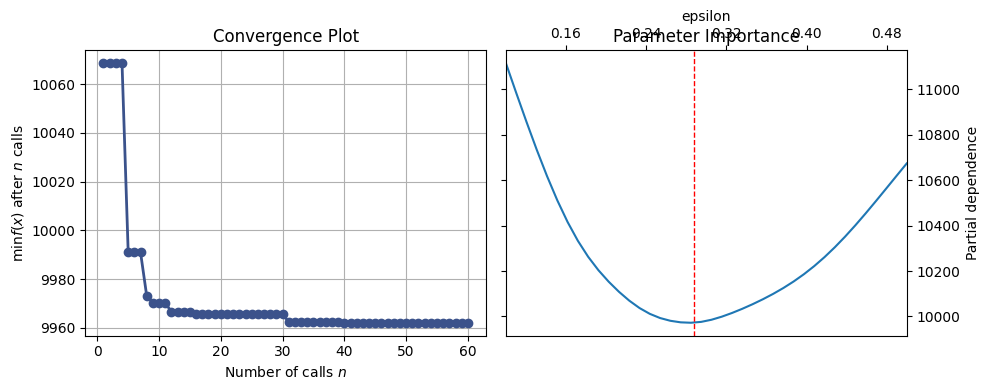

In [6]:
# Define parameter space for ShiftValueAgent
model_name = 'WSLS agent (long history)'
agent_class = WSLSAgent_custom

param_space = [
    Real(.1, .5, name='epsilon'),
]

fixed_params = {}

res_temp, behavior_temp = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, CV_splits=3, make_plots=True, n_calls=60, n_initial_points=10)
results[model_name] = res_temp
behaviors_simulated[model_name] = behavior_temp

res_temp

## 1. RL

### Simple RL agent

alpha              0.399438
beta               3.715977
LL_best       -12011.025326
BIC_best       24041.306514
LPT_best           0.453353
LL_CV          -4014.681116
LL_std           177.996706
BIC_CV          8046.420872
BIC_std          355.993413
LPT_CV             0.452555
LPT_std            0.015880
Reward rate        0.505230
Proba best         0.604800
dtype: float64

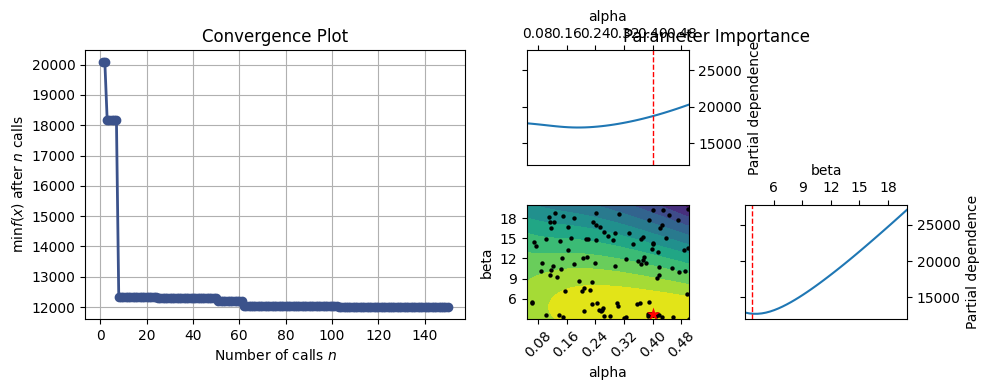

In [7]:
# Define parameter space for ShiftValueAgent
agent_class = QLearner
model_name = 'Q-Learner'

param_space = [
    Real(0.05, .5, name='alpha'),
    Real(3, 20.0, name='beta'),
]

fixed_params = {
    'structure_aware': False
}

res_temp, behavior_temp = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, CV_splits=3, make_plots=True, n_calls=150, n_initial_points=100)
results[model_name] = res_temp
behaviors_simulated[model_name] = behavior_temp

res_temp

### Counterfactual

alpha              0.151509
beta               4.605905
LL_best       -12636.373350
BIC_best       25292.002564
LPT_best           0.435060
LL_CV          -4227.510959
LL_std           272.096994
BIC_CV          8472.080558
BIC_std          544.193988
LPT_CV             0.434162
LPT_std            0.023689
Reward rate        0.500900
Proba best         0.591690
dtype: float64

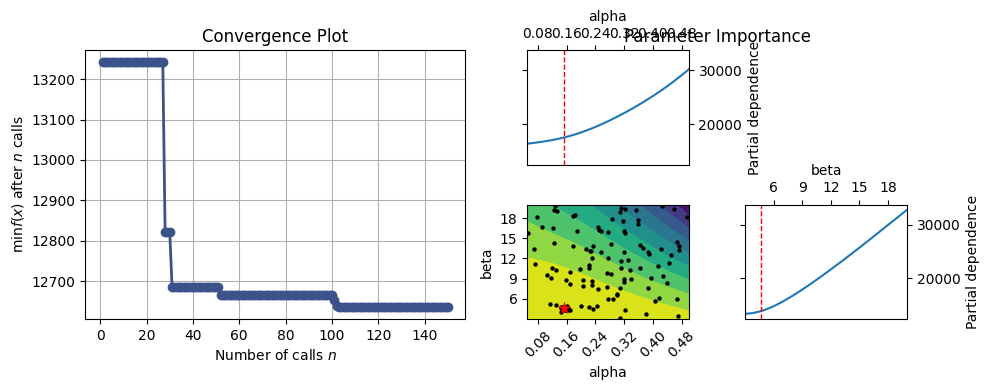

In [8]:
# Define parameter space for ShiftValueAgent
agent_class = QLearner
model_name = 'Q-Learner counterfactual'

param_space = [
    Real(0.05, .5, name='alpha'),
    Real(3, 20.0, name='beta'),
]

fixed_params = {
    'structure_aware': True
}

res_temp, behavior_temp = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, CV_splits=3, make_plots=True, n_calls=150, n_initial_points=100)
results[model_name] = res_temp
behaviors_simulated[model_name] = behavior_temp

res_temp

### Multiple learning rates

In [9]:
'''# Define parameter space for ShiftValueAgent
agent_class = QLearner
model_name = 'Q-Learner multiple alphas'

param_space = [
    Real(0.01, .6, name='alpha'),
    Real(0.01, .3, name='alpha_unchosen'),
    Real(3, 20.0, name='beta'),
]

fixed_params = {
    'structure_aware': True
}

res_temp, behav_q_learn_multiple = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, 
                                                model_name, make_plots=True,  verbose=False,
                                               n_calls=150, n_initial_points=100)
results_list.append(res_temp)
behaviors_simulated[model_name] = behav_q_learn_multiple'''

"# Define parameter space for ShiftValueAgent\nagent_class = QLearner\nmodel_name = 'Q-Learner multiple alphas'\n\nparam_space = [\n    Real(0.01, .6, name='alpha'),\n    Real(0.01, .3, name='alpha_unchosen'),\n    Real(3, 20.0, name='beta'),\n]\n\nfixed_params = {\n    'structure_aware': True\n}\n\nres_temp, behav_q_learn_multiple = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, \n                                                model_name, make_plots=True,  verbose=False,\n                                               n_calls=150, n_initial_points=100)\nresults_list.append(res_temp)\nbehaviors_simulated[model_name] = behav_q_learn_multiple"

## 2. Shift value

### No reset

alpha              0.434340
beta               5.467559
V0                 0.171883
LL_best        -8278.335124
BIC_best       16585.554043
LPT_best           0.579704
LL_CV          -2765.293508
LL_std           113.330267
BIC_CV          5556.174974
BIC_std          226.660533
LPT_CV             0.579132
LPT_std            0.013014
Reward rate        0.502130
Proba best         0.584740
dtype: float64

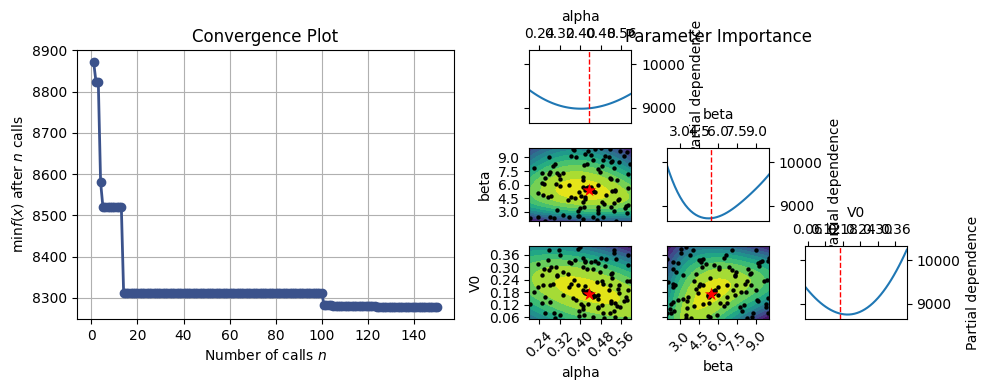

In [10]:
# Define parameter space for ShiftValueAgent
agent_class = ShiftValueAgent
model_name = 'Shift-value agent'

param_space = [
    Real(0.2, 0.6, name='alpha'),
    Real(2, 10.0, name='beta'),
    Real(0.05, .4, name='V0')
]

fixed_params = {
    'reset_on_switch': False
}

res_temp, behavior_temp = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, CV_splits=3, make_plots=True, n_calls=150, n_initial_points=100)
results[model_name] = res_temp
behaviors_simulated[model_name] = behavior_temp

res_temp

### Reset

alpha              0.293165
beta               6.991788
V0                 0.184301
LL_best        -7858.186309
BIC_best       15745.256413
LPT_best           0.595970
LL_CV          -2627.102742
LL_std           117.449722
BIC_CV          5279.793441
BIC_std          234.899445
LPT_CV             0.595170
LPT_std            0.013822
Reward rate        0.516760
Proba best         0.633050
dtype: float64

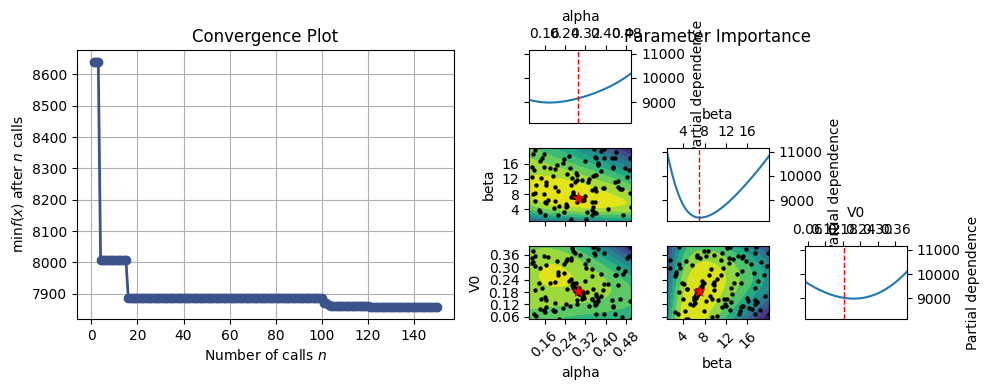

In [11]:
# Define parameter space for ShiftValueAgent
agent_class = ShiftValueAgent
model_name = 'Shift-value agent with reset'

param_space = [
    Real(0.1, 0.5, name='alpha'),
    Real(1, 20.0, name='beta'),
    Real(0.05, .4, name='V0')
]

fixed_params = {
    'reset_on_switch': True
}

res_temp, behavior_temp = fit_simulate(agent_class, param_space, env, behav_monkey, fixed_params, CV_splits=3, make_plots=True, n_calls=150, n_initial_points=100)
results[model_name] = res_temp
behaviors_simulated[model_name] = behavior_temp

res_temp

---
### Save Shift-value simulation

In [12]:
'''# show value function vs proba shift for threshold model
params = {'alpha': res_shift_threshold['alpha'], 'beta': res_shift_threshold['beta'], 'V0': res_shift_threshold['V0']}

fixed_params = {'reset_on_switch': True}
simulation = simulate_agent(ShiftValueAgent,
                            params=params,
                            env=env,
                            fixed_params={'reset_on_switch': True},
                            behavioral_variables=['Q'],
                            n_trials=len(behav_monkey))
                            
simulation = convert_column_format(simulation, original='simulation')

simulation['monkey'] = f'simulation_{monkey}'  # add change from 'simulation' to 'simulation_monkey' for plotting
simulation = simulation.rename(columns={'Q': 'value_function'})

# add metadata to the behav dataframe
simulation.attrs['model'] = 'Shift-value agent with reset'
simulation.attrs['parameters'] = params
simulation.attrs['fixed_parameters'] = fixed_params

from popy.config import PROJECT_PATH_LOCAL
floc = os.path.join(PROJECT_PATH_LOCAL, 'data', 'processed', 'behavior', f'simulation_{monkey}.pkl')
simulation.to_pickle(floc)
simulation'''

"# show value function vs proba shift for threshold model\nparams = {'alpha': res_shift_threshold['alpha'], 'beta': res_shift_threshold['beta'], 'V0': res_shift_threshold['V0']}\n\nfixed_params = {'reset_on_switch': True}\nsimulation = simulate_agent(ShiftValueAgent,\n                            params=params,\n                            env=env,\n                            fixed_params={'reset_on_switch': True},\n                            behavioral_variables=['Q'],\n                            n_trials=len(behav_monkey))\n                            \nsimulation = convert_column_format(simulation, original='simulation')\n\nsimulation['monkey'] = f'simulation_{monkey}'  # add change from 'simulation' to 'simulation_monkey' for plotting\nsimulation = simulation.rename(columns={'Q': 'value_function'})\n\n# add metadata to the behav dataframe\nsimulation.attrs['model'] = 'Shift-value agent with reset'\nsimulation.attrs['parameters'] = params\nsimulation.attrs['fixed_parameters'] = fi

## 3. HMM

The bayes has the best parameters in principle. Also we dont go with this model, and it has a lot of parameters.

---
# Summary

## Fitting statistics

In [17]:
res_all = pd.DataFrame.from_dict(results, orient='index').reset_index()
res_all = res_all.rename(columns={'index': 'Model'})

# remove Model=Q-Learner multiple alphas
res_all = res_all.loc[res_all['Model'].isin(['WSLS agent (long history)', 'Q-Learner', 'Q-Learner counterfactual', 'Shift-value agent with reset'])]

# save results
from popy.config import PROJECT_PATH_LOCAL
floc = os.path.join(PROJECT_PATH_LOCAL, 'notebooks', 'behav_modeling', 'results', f'simulation_results_{monkey}')
res_all.to_pickle(floc)

/var/folders/27/vz2x5s696jv_fnk5tpw5z1gw0000gn/T/ipykernel_60663/141671183.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
/var/folders/27/vz2x5s696jv_fnk5tpw5z1gw0000gn/T/ipykernel_60663/141671183.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')


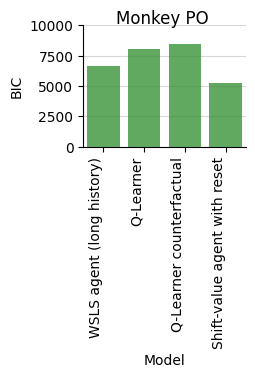

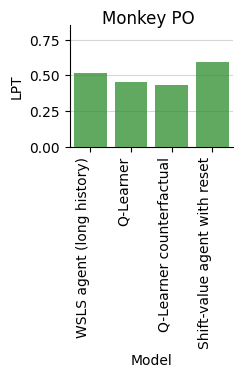

In [14]:
# show bic values
w = 4/6*8
h = 4

color = COLORS[monkey]

for mode in ['BIC_CV', 'LPT_CV']:
    fig, ax = plt.subplots(1, 1, figsize=(w/2.54, h/2.54))

    plt.suptitle(f'Monkey {monkey.upper()}')

    # show bic and ll values side by side for each model
    sns.barplot(data=res_all, x='Model', y=mode, ax=ax, zorder=10, alpha=0.8, color=color)

    #ax.set_title('BIC scores (cross-validated)')
    ax.set_ylabel(mode.split('_')[0])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.grid(axis='y', alpha=0.5, zorder=0)

    if mode == 'BIC_CV':
        ax.set_ylim(0, 10000)
    else:
        ax.set_ylim(0, .85)
        
        # save as svg
        floc = os.path.join('figs', f'{monkey}_lpt.svg')
        plt.savefig(floc, dpi=300, bbox_inches='tight')


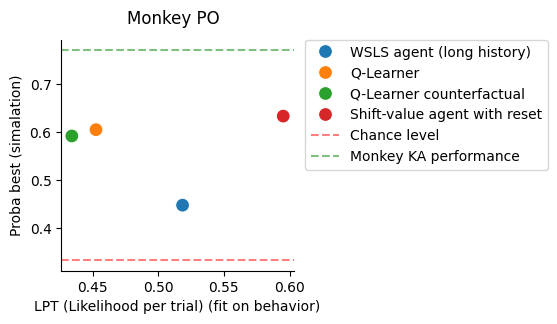

In [15]:
# show RPT vs Proba best
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

plt.suptitle(f'Monkey {monkey.upper()}')

sns.scatterplot(data=res_all, x='LPT_CV', y='Proba best', ax=ax, hue='Model', s=100)

ax.set_xlabel('LPT (Likelihood per trial) (fit on behavior)')
ax.set_ylabel('Proba best (simalation)')

ax.axhline(1/3, color='red', linestyle='--', alpha=0.5, label='Chance level')
ax.axhline(.77, color='green', linestyle='--', alpha=0.5, label='Monkey KA performance')

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#ax.set_xlim(.5, .8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## Behavioral characteristics

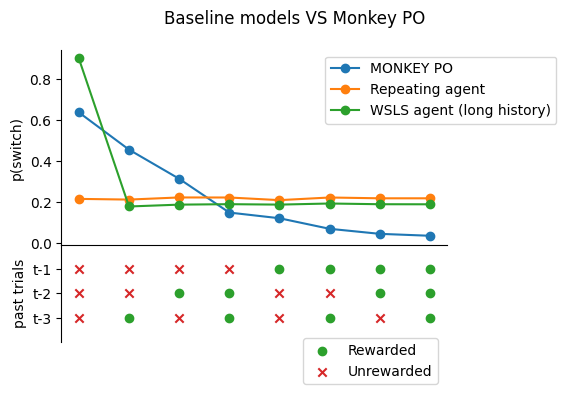

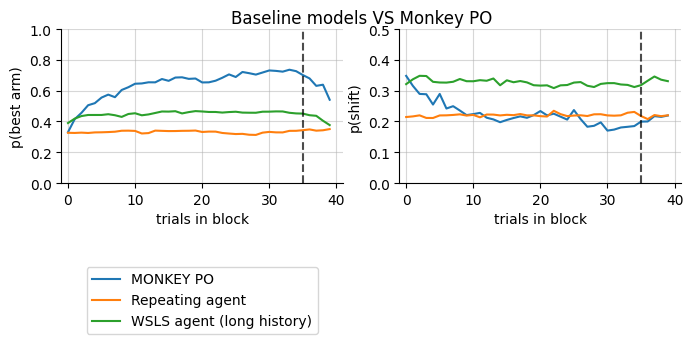

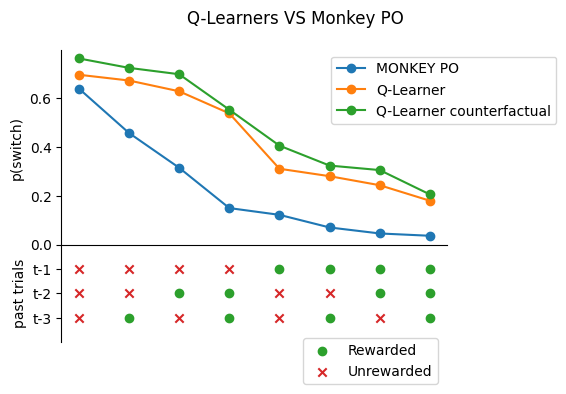

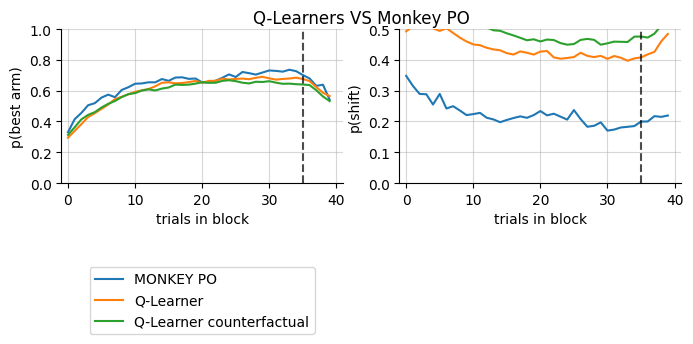

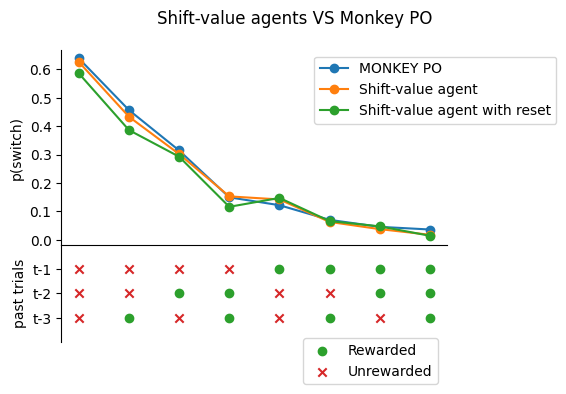

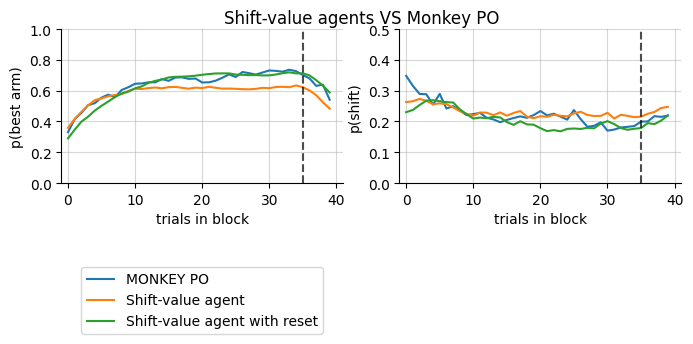

In [16]:
# monkey vs baseline models
behav_temp = {key: value for key, value in behaviors_simulated.items() if key in [f'MONKEY {monkey.upper()}', 'Repeating agent', 'WSLS agent (long history)']}
plot_hist_thingy(behav_temp, title='Baseline models VS Monkey {}'.format(monkey.upper()))
plot_summary_stats(behav_temp, title='Baseline models VS Monkey {}'.format(monkey.upper()))

# monkey vs q-learners
behav_temp = {key: value for key, value in behaviors_simulated.items() if key in [f'MONKEY {monkey.upper()}', 'Q-Learner', 'Q-Learner counterfactual']}
plot_hist_thingy(behav_temp, title='Q-Learners VS Monkey {}'.format(monkey.upper()))
plot_summary_stats(behav_temp, title='Q-Learners VS Monkey {}'.format(monkey.upper()))

# monkey vs shift-value agents
behav_temp = {key: value for key, value in behaviors_simulated.items() if key in [f'MONKEY {monkey.upper()}', 'Shift-value agent', 'Shift-value agent with reset']}
plot_hist_thingy(behav_temp, title='Shift-value agents VS Monkey {}'.format(monkey.upper()))
plot_summary_stats(behav_temp, title='Shift-value agents VS Monkey {}'.format(monkey.upper()))
